#### 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from matplotlib import font_manager, rc
%matplotlib inline
from matplotlib import cm 

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)

## 0. 데이터 불러오기

In [2]:
# 추정 매출 
buy_data = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_수정본.csv')
buy_data = buy_data.iloc[:,1:]

year_month = []
for i in range(buy_data.shape[0]):
    year_month.append(str(buy_data['기준_년_코드'].iloc[i]) + '-' + str(buy_data['기준_분기_코드'].iloc[i]))

buy_data['년-분기'] = year_month

# 대학 상권 list
college_commercial = pd.read_csv('./Data/대학인근상권.csv')
college_cm_name = list(college_commercial['TRDAR_CD_N'].unique())

# 상권 점포 데이터 
store_inf = pd.read_csv('./Data/서울시 우리마을가게 상권분석서비스(상권점포-통합).csv', low_memory=False)

### 해당 상권의 총 점포수 확인(프랜차이즈 점포수까지 확인)
store_inf['총_점포_수'] = store_inf['점포_수'] + store_inf['프랜차이즈_점포_수']

year_month = []
for i in range(store_inf.shape[0]):
    year_month.append(str(store_inf['기준_년_코드'].iloc[i]) + '-' + str(store_inf['기준_분기_코드'].iloc[i]))

store_inf['년-분기'] = year_month

## 1. 데이터 전처리(고정) 

- [1] 추정매출 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [2] 상권점포 데이터 中 상권 내에서 오탈자 문제: 종로?청계 관광특구(2020-4분기)
- [3] 상권점포 데이터 中 특정 분기에만 등장하는 상권 제거: 48개의 상권(2020-4분기)
- [4] 상권점포 데이터에서 각 상권별 서비스 업종 추출(22개 분기 모두 등장하는 업종만 추출)

In [3]:
# (1) 추정매출 데이터 내 오탈자 변경
buy_data['상권_코드_명'] = buy_data['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (2) 상권 점포 데이터 내 오탈자 변경
store_inf['상권_코드_명'] = store_inf['상권_코드_명'].agg(lambda x: '종로·청계 관광특구' if x =='종로?청계 관광특구' else x)

# (3) 상권 개수 맞춰서 진행하기
store_point_list = list(store_inf[store_inf['년-분기'] == "2016-1"]['상권_코드_명'].unique())
store_inf = store_inf.query('상권_코드_명 in @ store_point_list')

In [4]:
#(4) 상권별 - 서비스 업종이 22개 등장하는 업종만 뽑기 
find_value = (store_inf.groupby(['상권_코드','서비스_업종_코드_명'])[['기준_년_코드','기준_분기_코드']].count() == 22).reset_index()
find_value = find_value[(find_value['기준_년_코드'] == True)]

#### 22분기에 등장하는 상권-서비스 업종 대응 list
commercial_code = []
service_type_code = []
for i in find_value['상권_코드'].unique():
    commercial_code.append(i)
    value_list = []
    find_value_part = find_value[find_value['상권_코드'] == i]
    for j in find_value_part['서비스_업종_코드_명'].unique():
        value_list.append(j)
        value_list = list(set(value_list))
    service_type_code.append(value_list)
    
#### 각 상권코드를 가지고 와서 query문으로 데이터 정제
selected_data = []
for num,i in enumerate(commercial_code):  
    price_df_1 = store_inf[store_inf['상권_코드'] == i]
    find_servicetype_list = service_type_code[num]
    
    price_df_2 = price_df_1.query('서비스_업종_코드_명 in @ find_servicetype_list')    
    # 상권코드와 조합되는 서비스 업종 코드명으로 데이터 정제 후 저장
    
    selected_data.append(price_df_2)
    
data_cm = pd.concat(selected_data)
#data_cm.to_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')

store_inf = data_cm
store_inf = store_inf.reset_index(drop = True)

In [5]:
'''store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')
store_inf = store_inf.reset_indexd(drop = True)'''

"store_inf = pd.read_csv('서울시 우리마을가게 상권분석서비스(상권점포-통합)_수정본(전처리).csv')\nstore_inf = store_inf.reset_indexd(drop = True)"

## 2. 데이터 Clustering 

### (1) clustring 전처리 (scatter plot도 동시에 진행)

- 업종 소분류를 상위 개념끼리 묶음화(중분류 만들기) 후 '기타'항목 제거
   
   - 음식점류 : '한식음식점','양식음식점','분식전문점','중식음식점','치킨전문점','일식음식점', '패스트푸드점'
   - 디저트류: '커피-음료' ,'제과점'
   - 소매점류: '슈퍼마켓','편의점',
   - 주점류: '호프-간이주점'
   - 오락류: '당구장','노래방','PC방'
   - 미용뷰티류: '미용실','네일숍','화장품','피부관리실'
   - 기타류: 위의 것들은 제외한 모든 소분류
     
     
- 각 상권별 평균 점포수가 특정 값(thresholo) 낮으면 해당 상권 제거: 3 기준(변경 가능한 점)

#### 서비스 업종별 데이터 건수 확인

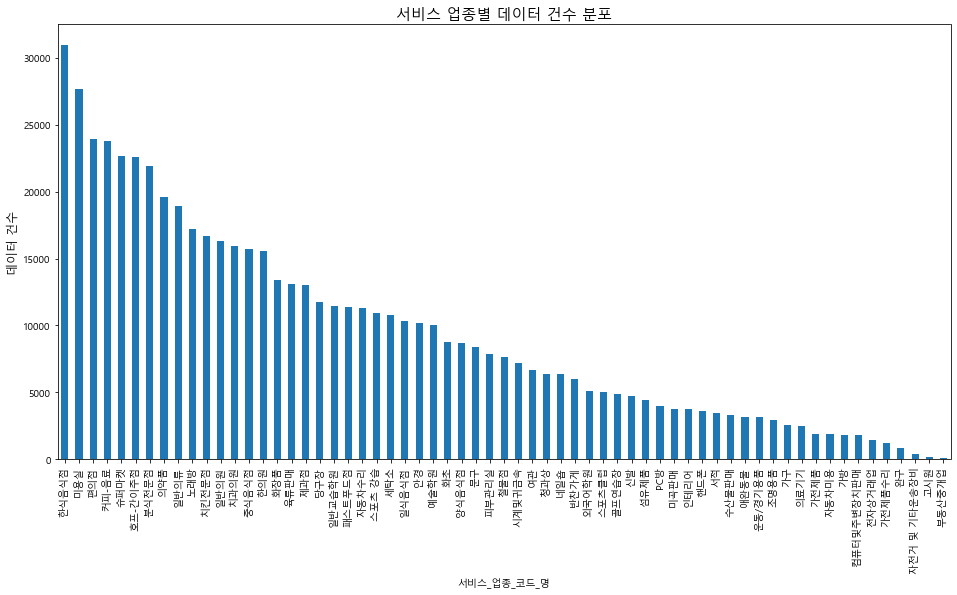

In [6]:
fig, ax = plt.subplots(figsize = (16,8))

buy_data.groupby('서비스_업종_코드_명')['점포수'].count().sort_values(ascending = False).plot.bar(cmap=plt.cm.tab20)
ax.set_title('서비스 업종별 데이터 건수 분포', fontsize = 15)
ax.set_ylabel('데이터 건수', fontsize = 12)
plt.show()

In [7]:
a = buy_data.pivot_table(columns = '년-분기', index = '상권_코드_명', values = '분기당_매출_금액', aggfunc = 'sum', fill_value = 0)

new = list(a.mean(axis = 1).sort_values(ascending = False).index)

In [8]:
# (1) clustring 전처리 - 추정매출 중분류 개념 생성

print("buy_data에 서비스 업종 종류: \n{}".format(list(buy_data.서비스_업종_코드_명.unique()))) # buy_data의 서비스 업종 확인

# 중분류 정의
food_type = ['한식음식점','양식음식점','분식전문점','패스트푸드점','중식음식점','치킨전문점','일식음식점']
desert_type = ['커피-음료' ,'제과점']
market_type = ['슈퍼마켓','편의점']
drunk_type = ['호프-간이주점'] 
game_type = ['당구장','노래방','PC방','골프연습장']
bueaty_type = ['미용실','네일숍','화장품','피부관리실']

# 
buy_data['서비스_업종_중분류'] = buy_data['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')

 # 기타 중분류는 분류에서 제외
data = buy_data[buy_data['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 대학상권만 가져오기
machul = data[data['상권_코드_명'].isin(college_cm_name)]
machul = machul.reset_index(drop=True)

buy_data에 서비스 업종 종류: 
['한식음식점', '편의점', '양식음식점', '분식전문점', '미용실', '제과점', '커피-음료', '한의원', '패스트푸드점', '가방', '일반의류', '슈퍼마켓', '중식음식점', '여관', '스포츠클럽', '세탁소', '당구장', '서적', '호프-간이주점', '반찬가게', '컴퓨터및주변장치판매', '시계및귀금속', '전자상거래업', '일식음식점', '치과의원', '치킨전문점', '의약품', '화초', '문구', '화장품', '핸드폰', '예술학원', '네일숍', '가구', '육류판매', '안경', '노래방', '외국어학원', '미곡판매', '자동차수리', '일반의원', '일반교습학원', '피부관리실', '조명용품', '의료기기', '인테리어', '가전제품', 'PC방', '애완동물', '스포츠 강습', '철물점', '청과상', '운동/경기용품', '섬유제품', '자동차미용', '신발', '골프연습장', '자전거 및 기타운송장비', '수산물판매', '가전제품수리', '완구', '부동산중개업', '고시원']


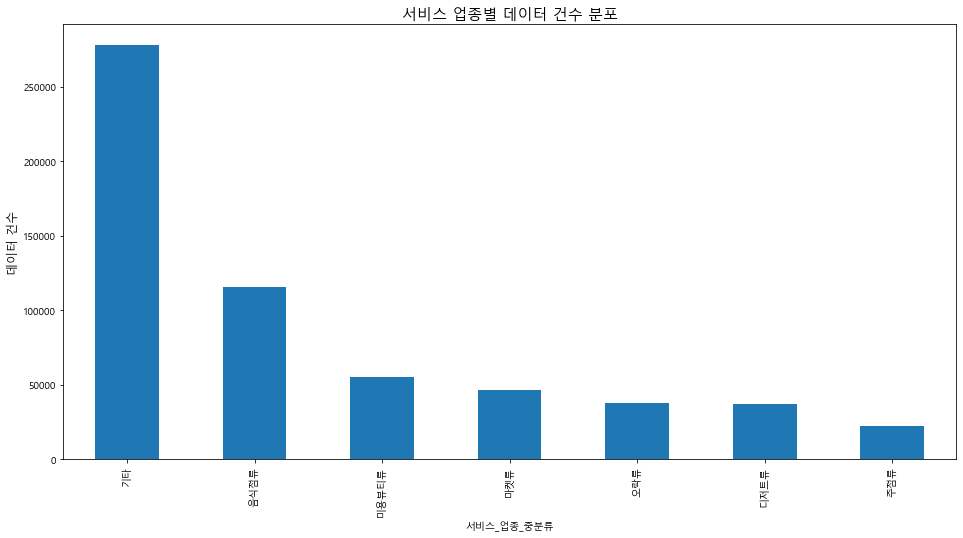

In [9]:
fig, ax = plt.subplots(figsize = (16,8))

buy_data.groupby('서비스_업종_중분류')['점포수'].count().sort_values(ascending = False).plot.bar(cmap=plt.cm.tab20)
ax.set_title('서비스 업종별 데이터 건수 분포', fontsize = 15)
ax.set_ylabel('데이터 건수', fontsize = 12)
plt.show()

In [10]:
# (2) 상권별 평균 점포수 확인
check = machul.pivot_table(index = '상권_코드_명', columns = '년-분기', values = '점포수', aggfunc = 'sum', 
                           fill_value = 0).sort_values(by = '2016-1')
check['평균_점포수'] = check.mean(axis = 1).round(2)

# 점포수가 적어 제거될 상권 + 추정매출 간의 이상 데이터가 있는 상권
except_cm = list(check.query('평균_점포수 <1').index) # + ['동호로20길', '새석관시장', '유영시장', '장위로50길']
print("점포수가 적어 제거될 상권: {}".format(except_cm))

# 해당 상권 제거
final_data = machul.query('상권_코드_명 != @except_cm').reset_index(drop=True)

print("최종 사용할 상권 수: {}개".format(len(final_data['상권_코드_명'].unique())))

점포수가 적어 제거될 상권: []
최종 사용할 상권 수: 315개


#### 상권 점포 전처리
- 싱권 점포에서 추정매출과의 데이터 동일성을 위해 동일한 전처리 진행 > (1) 
- 대학 상권 vs 서울 상권의 (코로나 기간: 2020년 이후) 개/폐업률 평균 비교

In [11]:
# 각 상권마다 중분류에서 기타를 제외한 부분을 추출
store_inf['서비스_업종_중분류'] =  store_inf['서비스_업종_코드_명'].agg(lambda x: '음식점류' if x in food_type else '디저트류' 
                                                     if x in desert_type else '마켓류' if x in market_type else '주점류' 
                                                     if x in drunk_type else '오락류' if x in game_type else '미용뷰티류' 
                                                     if x in bueaty_type else '기타')
reduce_store_inf = store_inf[store_inf['서비스_업종_중분류'] != '기타'].reset_index(drop = True)

# 상권점포-통합 데이터의 대학상권 추출
college_store_inf = reduce_store_inf .query('상권_코드_명 in @ college_cm_name')

# 추정매출간 점포수가 적었던 상권 제외 
college_store_inf = college_store_inf.query('상권_코드_명 != @except_cm').reset_index(drop=True)

display(store_inf.서비스_업종_중분류.unique())

array(['기타', '주점류', '음식점류', '디저트류', '미용뷰티류', '오락류', '마켓류'], dtype=object)

In [12]:
# 대학상권 분기별 개/폐업률 확인
college_store_cnt = college_store_inf.groupby('년-분기')['총_점포_수'].sum()         # 분기별 대학상권 점포수
college_openstore_cnt = college_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 대학상권 개업 점포 수
college_closestore_cnt = college_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 대학상권 폐업 점포 수

openstore_ratio_byquan = college_openstore_cnt / college_store_cnt * 100   # 분기별 대학상권 개업률
closestore_ratio_byquan = college_closestore_cnt / college_store_cnt  * 100 # 분기별 대학상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-2분기 이후) 평균을 구함
open_point_aftercovid = np.round(openstore_ratio_byquan.iloc[-6:].mean(), 3)  
close_point_aftercovid = np.round(closestore_ratio_byquan.iloc[-6:].mean(), 3)

display('대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid))
display('대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid))

'대학상권(주요 업종)의 (코로나 이후) 평균 개업률 : 3.075'

'대학상권(주요 업종)의 (코로나 이후) 평균 폐업률 : 3.335'

In [13]:
# 서울상권 분기별 개/폐업률 확인
store_cnt = reduce_store_inf.groupby('년-분기')['총_점포_수'].sum()        # 분기별 서울상권 점포수
openstore_cnt = reduce_store_inf.groupby('년-분기')['개업_점포_수'].sum()  # 분기별 서울상권 개업 점포 수
closestore_cnt = reduce_store_inf.groupby('년-분기')['폐업_점포_수'].sum() # 분기별 서울상권 폐업 점포 수

openstore_ratio_byquan_seoul = openstore_cnt / store_cnt * 100   # 분기별 서울상권 개업률
closestore_ratio_byquan_seoul = closestore_cnt / store_cnt * 100 # 분기별 서울상권 폐업률

## 코로나 후 이후 비교를 위해 (2020-2분기 이후) 평균을 구함
open_point_aftercovid_seoul = np.round(openstore_ratio_byquan_seoul.iloc[-6:].mean(), 3)  
close_point_aftercovid_seoul = np.round(closestore_ratio_byquan_seoul.iloc[-6:].mean(), 3)

display('서울상권의 (코로나 이후) 평균 개업률 : {}'.format(open_point_aftercovid_seoul))
display('서울상권의 (코로나 이후) 평균 폐업률 : {}'.format(close_point_aftercovid_seoul))

'서울상권의 (코로나 이후) 평균 개업률 : 3.368'

'서울상권의 (코로나 이후) 평균 폐업률 : 3.409'

#### clustring 

-  
- 

In [14]:
# 상권별 분기 매출금액
df = final_data.groupby(['상권_코드_명', '년-분기'])['분기당_매출_금액'].sum().reset_index()
df = df.rename(columns = {'분기당_매출_금액': '분기당_총매출금액'})

# seed 고정
seed = 0
np.random.seed(seed)

part_01_01 = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose()

# Task 1. 예년(2016 ~ 2018년도) 증감 평균

## 1.1 17년, 18년도(작년 대비) 증감율 

result_list = []
columne_name = []
index_name = list(part_01_01.index)

for num, year in enumerate([2017, 2018]):
    num = num * 4 
    
    for i in range(0,4,1):
        value = num + i                           # index 맞추기
        quarter = i + 1                           # 분기

        point = part_01_01.iloc[:,value]          # 이전 년도 분기
        comparison = part_01_01.iloc[:,value + 4] # 비교 년도 분기 
        
        quarterly_change = comparison.T.div(point).sub(1).round(4) # (비교 년도 분기 / 이전 년도 분기) - 1
        result_list.append(quarterly_change)                       # 값 추가하기 
        
        name = str(year) + '년도' + str(quarter) + '분기 증감율'  
        columne_name.append(name)
        
result_year_ofrat = pd.concat(result_list,axis = 1)       
result_year_ofrat.columns = columne_name


## 1.2 2개년도 증감율에 대한 평균(예년 증감 평균)
result_avg = []
result_column_name = []
for j in range(0,4,1):
    val = [j, j + 4]
    result_avg.append(result_year_ofrat.iloc[:, val].mean(axis = 1).round(4)) # 각 분기별 예년 증감 평균
    result_column = '{}분기 예년 증감 평균'.format(str(j+1))
    result_column_name.append(result_column)
    
result_before_covid = pd.concat(result_avg, axis = 1)
result_before_covid.columns = result_column_name

# Task 2. 2018년도 대비 2020년도 상권별 매출액 증감
column_name01 = [i for i in list(df['년-분기'].unique()) if '2018' in i]
column_name02 = [i for i in list(df['년-분기'].unique()) if '2020' in i]
column = column_name01 +column_name02

Incre_decre_rate = []
sales_inf_time = df.set_index(['년-분기','상권_코드_명'])['분기당_총매출금액'].unstack().transpose().loc[:,column]

for i in range(0,4,1):
    bef_point = sales_inf_time.T.iloc[i,:]       # 2018 년됴 매출액
    aft_point = sales_inf_time.T.iloc[i + 4,:]    # 2020 년도 매출액
    result_covid = aft_point.T.div(bef_point).sub(1).round(4).T
    Incre_decre_rate.append(result_covid)
    
result_after_covid = pd.concat(Incre_decre_rate, axis = 1)
result_after_covid.columns = ['2020년 1분기 증감', '2020년 2분기 증감', '2020년 3분기 증감', '2020년 4분기 증감']

# Task3. (feature로 사용할 코로나 영향도)

influence_of_covid_list = []

for i in range(0,4,1):
    before_point = result_before_covid.iloc[:,i]    # 예년 평균 증감
    after_point = result_after_covid.iloc[:, i]    # 코로나 이후 증감
    influence_of_covid = after_point - before_point
    influence_of_covid_list.append(influence_of_covid)
    
feature_01 = pd.concat(influence_of_covid_list, axis = 1)
feature_01.columns = ['1분기 covid 영향력','2분기 covid 영향력','3분기 covid 영향력','4분기 covid 영향력']

In [15]:
# feature 2 상권별 평균 점포 수
feature_02_01 = college_store_inf.pivot_table(index = '상권_코드_명', columns = '년-분기', 
                                        values = '총_점포_수', aggfunc = 'sum', fill_value = 0)
feature_02_01['상권_평균_점포수'] = feature_02_01.loc[:,:].mean(axis = 1).round()
feature_02_01 = feature_02_01[['상권_평균_점포수']]
step_01 = feature_02_01.copy()

from sklearn.preprocessing import RobustScaler

step_01.iloc[:,:] = np.log(step_01.iloc[:,:])
# 점포 수에 대한 scaling 진행 
trans = RobustScaler()
feature_02_01_scaling = trans.fit_transform(step_01)

# scaling 데이터프레임화 
feature_02_01_scaling = pd.DataFrame(feature_02_01_scaling).round(4)
feature_02_01_scaling.index = list(feature_02_01.index)
feature_02_01_scaling.columns = ['상권_평균_점포수(scaling)']
feature_02_01_scaling = feature_02_01_scaling.reset_index().rename(columns = {'index' : '상권_코드_명'}).set_index('상권_코드_명')

# 데이터 프레임 합치기
result = pd.merge(feature_01.reset_index(), feature_02_01.reset_index(), on = '상권_코드_명').set_index('상권_코드_명')
result.head(1)

# scaling 데이터 프레임 합치기 
part_scaling = pd.merge(feature_02_01.reset_index(), feature_02_01_scaling.reset_index(), 
                        on = '상권_코드_명')[['상권_코드_명','상권_평균_점포수(scaling)','상권_평균_점포수']]

result_scaling = pd.merge(feature_01.reset_index(), part_scaling, on = '상권_코드_명').set_index('상권_코드_명')

#### clustring

segment
0     21
1     28
2     47
3     50
4      8
5      2
6     13
7      1
8     44
9     11
10     6
11     4
12    35
13    17
14    28
dtype: int64

segment
0      244.0
1       37.0
2       47.0
3       74.0
4       28.0
5     2740.0
6      662.0
7        8.0
8       70.0
9       14.0
10      86.0
11       5.0
12     118.0
13      23.0
14     135.0
Name: 상권_평균_점포수, dtype: float64

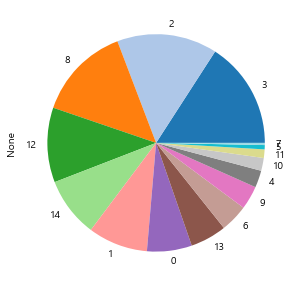

C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 

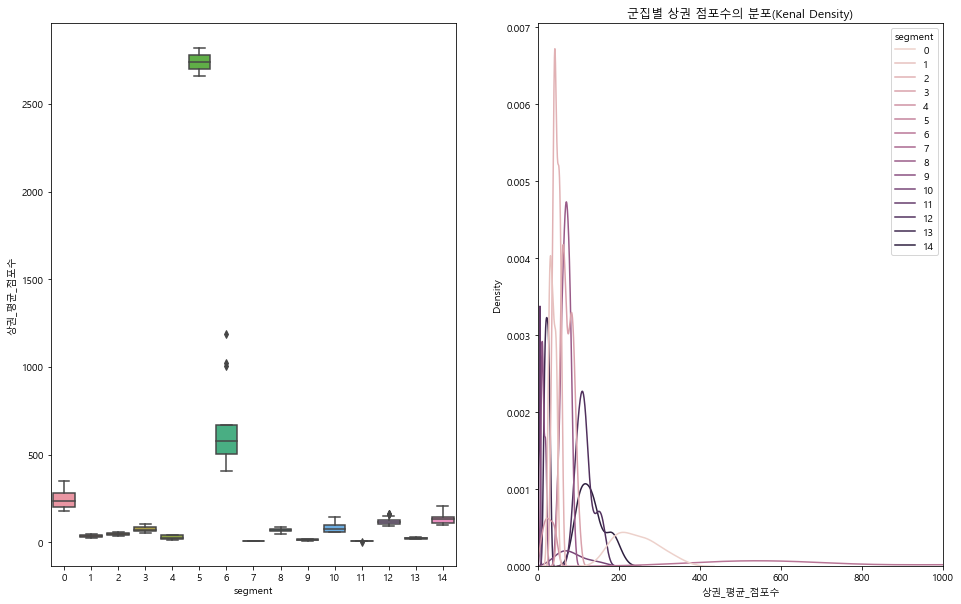

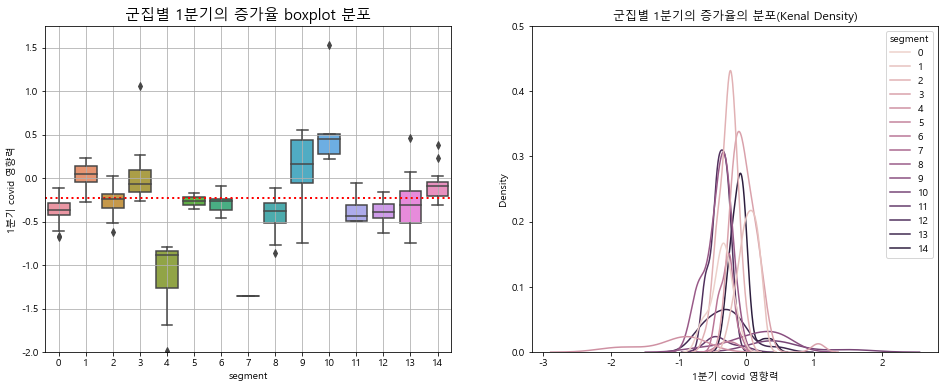

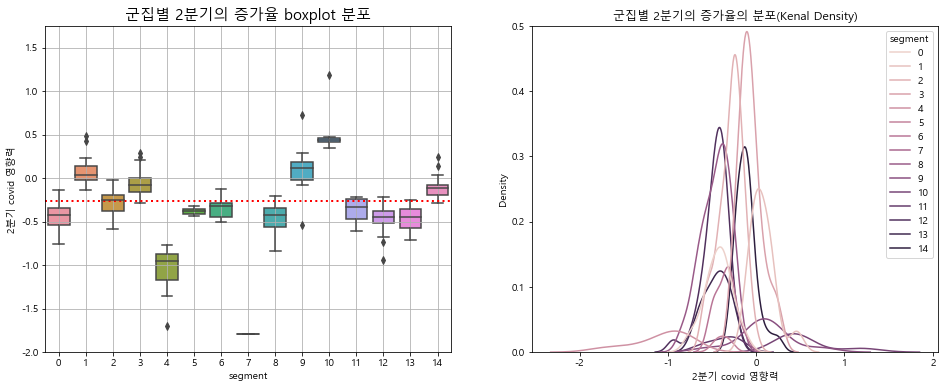

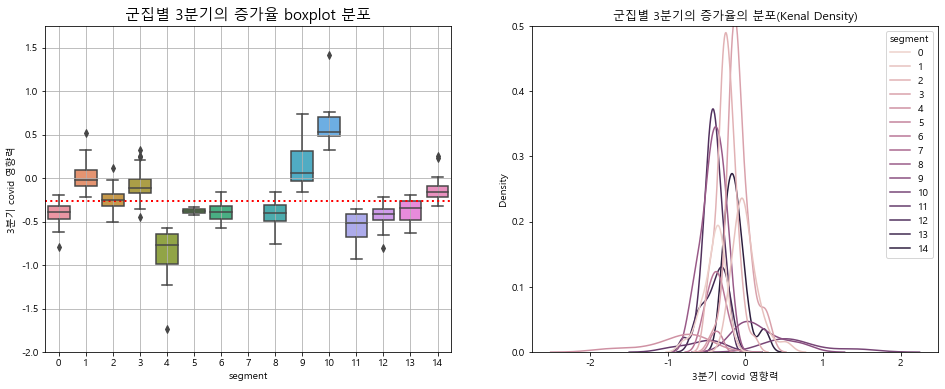

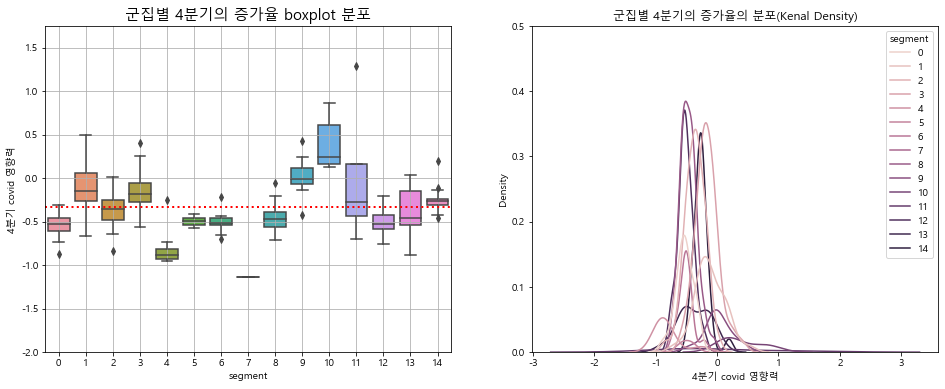

In [16]:
k = 15
for i in [k]:
    result_final = result_scaling.copy()
    inf_covid = feature_01.copy()
    inf_covid = inf_covid.reset_index()
    
    # 0.kmean 적용 후 결과를 저장
    kmeans = KMeans(n_clusters=i, random_state=0).fit(result_final.iloc[:,:-1])
    result_final['segment'] = kmeans.labels_
    
    labels = result_final.value_counts('segment')[result_final.value_counts('segment') > 5].sort_index().index
    
    ## 군집에 대한 시각화
    
    # 1-1 segment별 분포 확인
    plt.figure(figsize=(16, 10))
    
    display(result_final.value_counts('segment').sort_index())
    display(result_final.groupby('segment')['상권_평균_점포수'].mean().round(0))
    
    # 1-2 파이 그래프로 확인
    result_final.value_counts('segment').plot.pie(cmap=plt.cm.tab20, figsize = (14,5))
    plt.show()
    
    
    ## 점포수의 시각화
    
    # 2-1 각 군집별 상권 점포 수의 boxplot
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='segment', y='상권_평균_점포수', data = result_final)
    
    # 2-2  각 군집별 상권 점포 수의 밀도(분포)
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=result_final, x= "상권_평균_점포수", hue="segment")
    plt.xlim([0,1000])
    plt.title('군집별 상권 점포수의 분포(Kenal Density)')
    
    
    ## 각 군집별 코로나 영향도 확인
    
    for n, col_name in enumerate(['1분기 covid 영향력', '2분기 covid 영향력' ,'3분기 covid 영향력', '4분기 covid 영향력']): 
        col = col_name[:3]
        avg = np.round(feature_01.iloc[:, n].mean(),3)
        
        plt.figure(figsize=(16, 6))

        # 3.1 각 군집별 코로나의 boxplot
        plt.subplot(1, 2, 1)
        sns.boxplot(x='segment', y= col_name , data = result_final)
        plt.title('군집별 {}의 증가율 boxplot 분포'.format( col), size=15)
        plt.ylim([-2.0, 1.75])
        plt.axhline(y = avg, color = 'red', linestyle = ':',linewidth=2)
        
        plt.grid()
        
        # 3.1 각 군집별 코로나의 분포
        plt.subplot(1, 2, 2)
        sns.kdeplot(data = result_final, x= col_name, hue="segment")
        plt.title('군집별 {}의 증가율의 분포(Kenal Density)'.format(col))
        plt.ylim([0, 0.5])
        
    plt.show()

#### 데이터 저장 / 군집확인

In [17]:
 result_final.query('segment == 4').index   # 엄청 낮음

Index(['사당로23나길', '삼선교로10다길', '삼선교로16가길', '서달로14길', '아현가구거리상점가', '용답중앙길',
       '홍연길', '화랑로19길'],
      dtype='object', name='상권_코드_명')

In [18]:
 result_final.query('segment == 10')  # 0보다 큼

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수,segment
상권_코드_명,,,,,,,
경인로35길,0.2224,0.4697,0.4712,0.2015,0.4830,105.0,10
고척근린시장,1.5328,1.1884,1.4205,0.8699,-0.1928,56.0,10
아현시장,0.4857,0.3479,0.3249,0.1244,0.2558,85.0,10
왕십리로14길,0.2332,0.4071,0.7628,0.7239,0.0000,67.0,10
증가로23나길,0.5087,0.4425,0.5107,0.1474,0.8374,146.0,10
퇴계로18길,0.4152,0.4432,0.5401,0.2827,-0.1738,57.0,10


In [19]:
 result_final.query('segment == 6')  # 0보다 큼

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수,segment
상권_코드_명,,,,,,,
강서구청,-0.2584,-0.2220,-0.2514,-0.4569,2.0452,449.0,6
교대역_1,-0.0881,-0.1298,-0.1645,-0.2125,2.4755,670.0,6
남대문시장,-0.2613,-0.3003,-0.4709,-0.5508,2.3130,576.0,6
명동거리,-0.2281,-0.3839,-0.3907,-0.4702,2.9316,1024.0,6
서울 광진구 건대입구역_2,-0.4525,-0.4965,-0.5726,-0.6954,2.2594,548.0,6
서울 노원구 노원역_3,-0.4187,-0.4411,-0.4666,-0.5370,2.2476,542.0,6
서울 서대문구 신촌역,-0.3979,-0.5089,-0.5251,-0.6580,3.0922,1189.0,6
서울 서대문구 이대역,-0.3699,-0.4671,-0.4183,-0.5367,2.3886,618.0,6
서울 성북구 성신여대입구역,-0.3340,-0.3612,-0.4008,-0.5423,2.1630,501.0,6


In [20]:
 result_final.query('segment == 9')  # 0보다 큼

,1분기 covid 영향력,2분기 covid 영향력,3분기 covid 영향력,4분기 covid 영향력,상권_평균_점포수(scaling),상권_평균_점포수,segment
상권_코드_명,,,,,,,
강남시장_동작,0.5530,0.0509,-0.0434,-0.4214,-1.9425,11.0,9
개봉중앙시장,0.0237,-0.0720,-0.0382,-0.0066,-1.8489,12.0,9
밤나무골시장,0.5308,0.1858,0.0569,-0.1387,-2.1582,9.0,9
백운시장,-0.7397,-0.5330,0.1928,0.1757,-1.8489,12.0,9
서달로10길,-0.3321,0.1118,0.2684,0.2389,-1.6832,14.0,9
이경시장,0.1578,0.0222,0.0052,0.0514,-2.0450,10.0,9
이문제일시장,0.0987,0.1272,0.3596,0.0097,-1.8489,12.0,9
장위로50길,-0.1453,0.2907,0.6035,-0.0377,-1.3549,19.0,9
창신길,0.3875,-0.0777,-0.1564,-0.0669,-1.4745,17.0,9


- 시각화
[1] https://seaborn.pydata.org/generated/seaborn.FacetGrid.html#seaborn.FacetGrid
[2] https://velog.io/@ruinak_4127/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D-%EB%B0%8F-%EA%B2%B0%EA%B3%BC-%EC%8B%9C%EA%B0%81%ED%99%94


#### 1. segment별 boxplot 확인

In [21]:
### 원본데이터 Frame
new = feature_01.reset_index()
eda_01 = pd.merge(new, result_final.reset_index()[['상권_코드_명','상권_평균_점포수','segment']], on ='상권_코드_명')

### 분기 분할
qur_01_inpact = eda_01[['상권_코드_명','1분기 covid 영향력','segment']].rename(columns = {'1분기 covid 영향력': 'covid 영향력'})
qur_02_inpact = eda_01[['상권_코드_명','2분기 covid 영향력','segment']].rename(columns = {'2분기 covid 영향력': 'covid 영향력'})
qur_03_inpact = eda_01[['상권_코드_명','3분기 covid 영향력','segment']].rename(columns = {'3분기 covid 영향력': 'covid 영향력'})
qur_04_inpact = eda_01[['상권_코드_명','4분기 covid 영향력','segment']].rename(columns = {'4분기 covid 영향력': 'covid 영향력'})

## 분기 feature 추가 
qur_01_inpact['분기'] = '1분기'
qur_02_inpact['분기'] = '2분기'
qur_03_inpact['분기'] = '3분기'
qur_04_inpact['분기'] = '4분기'

# 데이터 합치기
fact_01 = pd.concat([qur_01_inpact, qur_02_inpact, qur_03_inpact, qur_04_inpact], axis =0).reset_index().iloc[:,1:]
fact_01 = fact_01.sort_values(by = ['상권_코드_명','분기']).reset_index().iloc[:,1:]
fact_01.head(10)

,상권_코드_명,covid 영향력,segment,분기
0,가재울로6길,-0.0882,3,1분기
1,가재울로6길,-0.0809,3,2분기
2,가재울로6길,-0.1377,3,3분기
3,가재울로6길,-0.1224,3,4분기
4,가좌로7길,-0.1340,2,1분기
5,가좌로7길,-0.2421,2,2분기
6,가좌로7길,-0.1896,2,3분기
7,가좌로7길,-0.2484,2,4분기
8,갈현로1길,-0.6338,8,1분기
9,갈현로1길,-0.6049,8,2분기


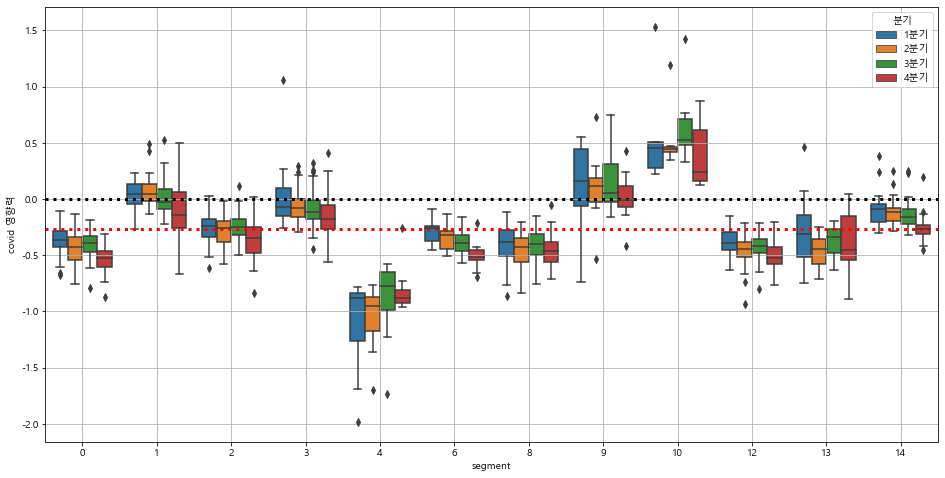

In [22]:
fig, ax = plt.subplots(figsize = (16,8))

# order = order = [i for i in range(0, k, 1)]
total_avg = round(fact_01['covid 영향력'].mean(),4)

sns.boxplot(x = "segment", y = "covid 영향력", hue = "분기", data = fact_01.query('segment in @labels'), ax = ax)
plt.axhline(y = 0, color = 'black', linestyle = ':',linewidth = 3)
plt.axhline(y = total_avg, color = 'red', linestyle = ':',linewidth = 3)

plt.grid()
plt.show()

#### 각 군집별 (분기에 따른 covid 영향력 분포) 분포

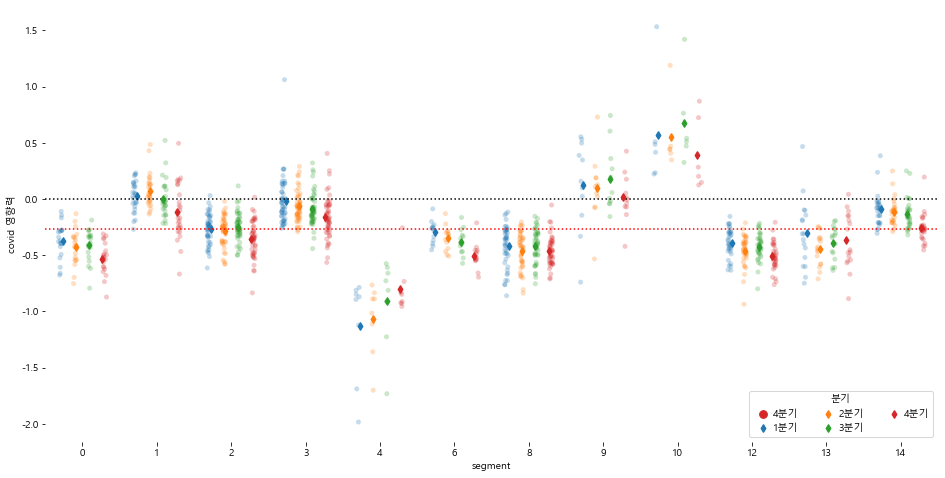

In [23]:
# Conditional means with observations
f, ax = plt.subplots(figsize = (16,8))
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="segment", y="covid 영향력", hue="분기", data=fact_01.query('segment in @labels'), 
              dodge=True, alpha=.25, zorder=1)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(x="segment", y="covid 영향력", hue="분기", data=fact_01.query('segment in @labels'), 
              dodge=.8 - .8 / 3, join=False,markers="d", scale=.75, ci=None)

# Improve the legend
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[3:], label[3:], title="분기",
          handletextpad=0, 
          loc="lower right", ncol=3, frameon=True)

plt.axhline(y = 0, color = 'black', linestyle = ':',linewidth = 1.5)
plt.axhline(y = total_avg, color = 'red', linestyle = ':',linewidth = 1.5)
plt.show()

#### 각 군집별 density(분기 전체)

C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


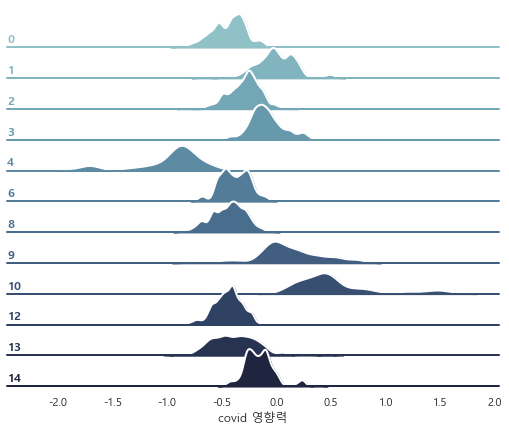

In [24]:
# 각 군집려 density 보여주기
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)


# the FacetGrid object
pal = sns.cubehelix_palette(len(fact_01.query('segment in @labels').segment.unique()), rot=-.25, light=.7)
g = sns.FacetGrid(fact_01.query('segment in @labels'), row = "segment" , hue="segment", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "covid 영향력",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "covid 영향력", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
g.map(label, "covid 영향력")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()

#### 구분이 되는 군집에 대한 비교

C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\gby1349\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


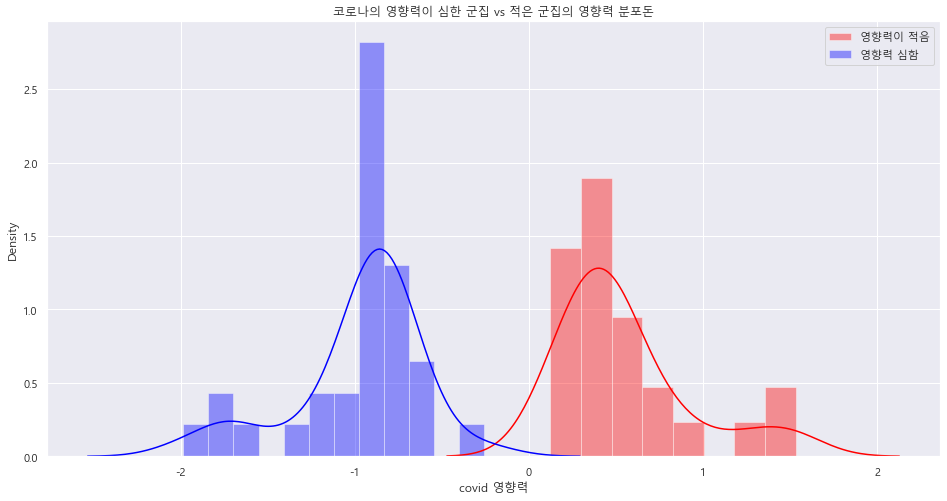

In [25]:
sns.set_theme(style="darkgrid")

# 한글 폰트
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

pd.set_option('max_columns', 100, 'max_rows', 20)


### 위의 선택한 군집에 대한 plot 그림
def high_low(high, low):
    fig, ax = plt.subplots(figsize = (16,8))
    up_value = fact_01.loc[fact_01['segment'] == high, 'covid 영향력']
    sns.distplot(up_value, kde = True, color = "red", label = '영향력이 적음', ax = ax)

    down_value = fact_01.loc[fact_01['segment'] == low, 'covid 영향력']
    sns.distplot(down_value, kde = True, color = "blue", label = '영향력 심함', ax = ax)

    plt.title("코로나의 영향력이 심한 군집 vs 적은 군집의 영향력 분포돈")
    plt.legend()
    plt.show()
    
high_low(10,4)

#### 홍록님꺼 (1)

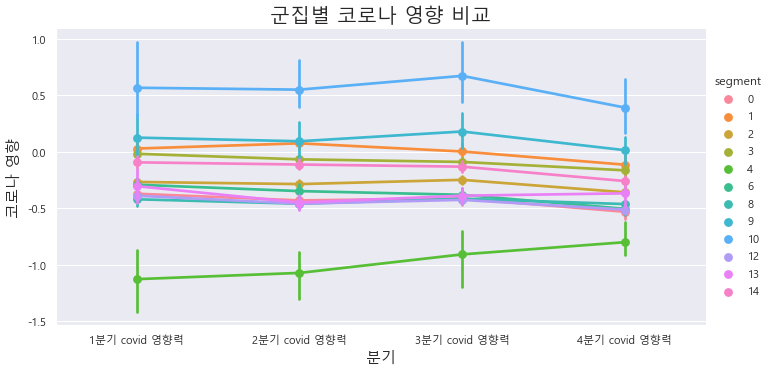

In [26]:
melt_value = result_final[['1분기 covid 영향력' ,'2분기 covid 영향력', 
                           '3분기 covid 영향력', '4분기 covid 영향력','segment']].query('segment in @labels')

melt = melt_value .reset_index().melt(id_vars=['segment', '상권_코드_명'])

sns.catplot(x='variable', y='value', hue='segment', kind='point', data=melt, aspect=2, figsize = (20,10))
plt.xticks(range(4), ['1분기 covid 영향력', '2분기 covid 영향력', '3분기 covid 영향력', '4분기 covid 영향력'])
plt.ylabel('코로나 영향', size=15)
plt.xlabel('분기', size=15)
plt.title('군집별 코로나 영향 비교', size=20)
plt.show()

#### 홍록님꺼 (2)

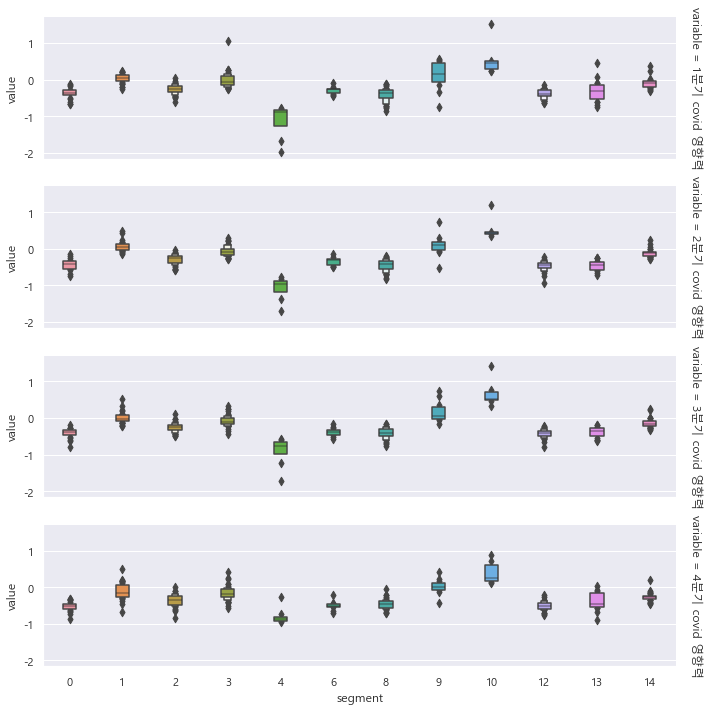

In [27]:
g = sns.catplot(x='segment', y='value', kind='boxen', row='variable', data=melt, aspect=4, 
            height=2.5, width=0.25, sharex=True, margin_titles=True)

#### 2. segment별 boxplot 확인

In [28]:
### 원본데이터 Frame(코로나 이후 vs 이전 증감율)
after_new = result_after_covid.reset_index()
after_new  = pd.merge(after_new, result_final.reset_index()[['상권_코드_명','segment']], on ='상권_코드_명')

before_new = result_before_covid.reset_index()
before_new = pd.merge(before_new, result_final.reset_index()[['상권_코드_명','segment']], on ='상권_코드_명')

eda_02 = pd.merge(before_new, after_new, on = ['상권_코드_명','segment'])

### 분기 분할
qur_01_cre = eda_02[['상권_코드_명','1분기 예년 증감 평균',
                     '2020년 1분기 증감','segment']].rename(columns = {'1분기 예년 증감 평균': '예년 증감 평균', 
                                                                      '2020년 1분기 증감' : '2020년 증감'})
qur_02_cre = eda_02[['상권_코드_명','2분기 예년 증감 평균',
                     '2020년 2분기 증감','segment']].rename(columns = {'2분기 예년 증감 평균': '예년 증감 평균', 
                                                                      '2020년 2분기 증감' : '2020년 증감'})
qur_03_cre = eda_02[['상권_코드_명','3분기 예년 증감 평균',
                     '2020년 3분기 증감','segment']].rename(columns = {'3분기 예년 증감 평균': '예년 증감 평균', 
                                                                      '2020년 3분기 증감' : '2020년 증감'})
qur_04_cre = eda_02[['상권_코드_명','4분기 예년 증감 평균',
                     '2020년 4분기 증감','segment']].rename(columns = {'4분기 예년 증감 평균': '예년 증감 평균', 
                                                                      '2020년 4분기 증감' : '2020년 증감'})

## 분기 feature 추가 
qur_01_cre['분기'] = '1분기'
qur_02_cre['분기'] = '2분기'
qur_03_cre['분기'] = '3분기'
qur_04_cre['분기'] = '4분기'

# 데이터 합치기
fact_02 = pd.concat([qur_01_cre, qur_02_cre, qur_03_cre, qur_04_cre], axis =0).reset_index().iloc[:,1:]
fact_02 = fact_02.sort_values(by = ['상권_코드_명','분기']).reset_index().iloc[:,1:]
fact_02.head(10)

,상권_코드_명,예년 증감 평균,2020년 증감,segment,분기
0,가재울로6길,0.0402,-0.0480,3,1분기
1,가재울로6길,0.0407,-0.0402,3,2분기
2,가재울로6길,0.0522,-0.0855,3,3분기
3,가재울로6길,0.0372,-0.0852,3,4분기
4,가좌로7길,0.0956,-0.0384,2,1분기
5,가좌로7길,0.1279,-0.1142,2,2분기
6,가좌로7길,0.0996,-0.0900,2,3분기
7,가좌로7길,0.1110,-0.1374,2,4분기
8,갈현로1길,0.2498,-0.3840,8,1분기
9,갈현로1길,0.2525,-0.3524,8,2분기


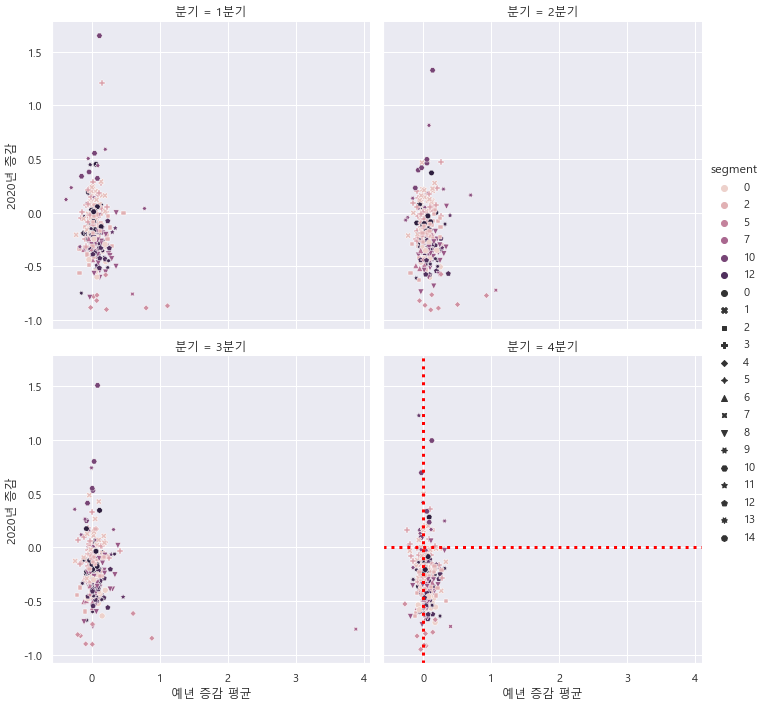

In [29]:
g = sns.relplot(x = "예년 증감 평균", y =  "2020년 증감", style="segment", hue = 'segment', col="분기", 
                data = fact_02, col_wrap=2, sizes=(10, 200))

plt.axhline(y = 0, color = 'red', linestyle = ':',linewidth = 3)
plt.axvline(x = 0, color = 'red', linestyle = ':',linewidth = 3)

#### 내용 정리

- 포함할 경우 
    - 증가 군집[군집 10번] : '경인로35길', '고척근린시장', '아현시장', '왕십리로14길', '증가로23나길', '퇴계로18길'
    - 감소 군집 [군집 4번] : '사당로23나길', '삼선교로10다길', '삼선교로16가길', '서달로14길', '아현가구거리상점가', '용답중앙길', '홍연길', '화랑로19길
    
    
- 포함하지 않는 경우 